# 基于Pytorch的深度学习奶龙图像检测应用

## 引入依赖

In [272]:
import os
from matplotlib import rcParams
# 设置字体为黑体
rcParams['font.sans-serif'] = ['SimHei']  # 指定字体
rcParams['axes.unicode_minus'] = False   # 解决负号显示问题
import numpy as np
import torch
from torch import nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import time
import warnings
warnings.filterwarnings("ignore")
import copy

## 配置数据源

In [273]:

data_transforms = {
    # 组合训练集的数据集组件
    'train':transforms.Compose([
        transforms.Resize([96,96]), # 将用于训练的图像统一裁剪为96x96的大小，以适应模型输入
        # 数据增强部分，随机水平垂直翻转图像，提高模型的泛化能力
        transforms.RandomRotation(45), # 随机旋转图像-45到45度
        transforms.CenterCrop(64), # 从中心裁剪64x64的图像
        transforms.RandomHorizontalFlip(p=0.5), # 随机水平翻转图像
        transforms.RandomVerticalFlip(p=0.5), # 随机垂直翻转图像
        transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1), # 随机调整图像的亮度、对比度、饱和度和色调
        transforms.RandomGrayscale(p=0.025) , # 随机将图像转换为灰度图像
        transforms.ToTensor(), # 将图像转换为张量
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 对图像进行归一化处理
    ]),
    # 组合验证集的数据集组件，注意这里的组件要和训练集的部分组件一致
    'valid':transforms.Compose([
        transforms.Resize([46,46]), # 将用于训练的图像统一裁剪为46x46的大小，以适应模型输入
        transforms.ToTensor(), # 将图像转换为张量
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 对图像进行归一化处理
    ]),
}

## 数据集初始化

In [274]:
data_dir = os.path.abspath("../data")

# 配置batch_size为128
batch_size = 128

# 使用DataLoader加载数据集
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid']
}

# 创建数据加载器
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) for x in ['train', 'valid']
}

# 查看数据集大小
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}

# 查看类别
class_names = image_datasets['train'].classes

In [275]:
# 选择预训练模型
model_name = 'resnet18'
model_checkpoint_filename = '../best.pt'
# 模型分类数
model_classes_num = 2
feature_extract = True

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
    return model

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0
    if model_name == "resnet18":
        model_ft = models.resnet18(pretrained=use_pretrained)
    elif model_name == 'resnet50':
        model_ft = models.resnet50()
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    input_size = 64
    return model_ft, input_size


# 初始化模型
model_ft, input_size = initialize_model(model_name, model_classes_num, feature_extract, use_pretrained=True)

# 设置模型的运行设备(cpu/gpu)
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    print('GPU is available')
else:
    print('GPU is not available')
device = torch.device("cuda:0" if train_on_gpu else "cpu")
model_ft = model_ft.to(device)

# 是否训练所有层
params_to_update = model_ft.fc.parameters()

print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)



GPU is not available
Params to learn:
	 fc.weight
	 fc.bias


In [276]:
# 优化器设置(这里只添加本轮需要训练的参数)
optimizer_ft = optim.Adam(params_to_update, lr=1e-2)
# 学习率递减策略
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1) # 每10个epoch，学习率降低10倍
# 损失函数设置
criterion = nn.CrossEntropyLoss()

In [277]:
# 训练模型
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25,save_path='./best.pt'):
    # 开始训练时的时间
    since = time.time()
    # 最好的模型参数
    best_model_wts = copy.deepcopy(model.state_dict())
    # 最好的ACC
    best_acc = 0.0

    # 遍历epoch
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 每个epoch都分为训练和验证两个阶段
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # 设置模型为训练模式
            else:
                model.eval()   # 设置模型为评估模式

            running_loss = 0.0
            running_corrects = 0
            # 遍历数据集
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 梯度清零
                optimizer.zero_grad()

                # 前向传播
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs) # 获取模型输出
                    _, preds = torch.max(outputs, 1) # 获取预测结果
                    loss = criterion(outputs, labels) # 计算损失

                    # 反向传播和优化，仅在训练阶段进行
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 统计
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step() # 学习率递减

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # 保存最好的模型
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                # 保存最好的模型参数
                torch.save({
                    'state_dict':model.state_dict(),
                    'best_acc':best_acc,
                    'optimizer':optimizer
                }, save_path)
                print(f"Saved best model to {save_path}")

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 加载最好的模型权重
    model.load_state_dict(best_model_wts)
    return model

In [278]:
model_ft = train_model(model_ft,dataloaders,criterion,optimizer_ft,scheduler,num_epochs=25,save_path=model_checkpoint_filename)

Epoch 0/24
----------
train Loss: 0.8002 Acc: 0.5400
valid Loss: 0.2949 Acc: 0.8911
Saved best model to ../best.pt
Epoch 1/24
----------
train Loss: 0.5134 Acc: 0.6800
valid Loss: 2.0015 Acc: 0.3762
Epoch 2/24
----------
train Loss: 0.5578 Acc: 0.7400
valid Loss: 1.5128 Acc: 0.5545
Epoch 3/24
----------
train Loss: 0.2866 Acc: 0.8600
valid Loss: 0.6633 Acc: 0.8020
Epoch 4/24
----------
train Loss: 0.1215 Acc: 0.9400
valid Loss: 0.3627 Acc: 0.8515
Epoch 5/24
----------
train Loss: 0.1807 Acc: 0.9000
valid Loss: 0.3297 Acc: 0.8614
Epoch 6/24
----------
train Loss: 0.1592 Acc: 0.9400
valid Loss: 0.4338 Acc: 0.8218
Epoch 7/24
----------
train Loss: 0.1622 Acc: 0.9200
valid Loss: 0.6744 Acc: 0.8020
Epoch 8/24
----------
train Loss: 0.0926 Acc: 0.9800
valid Loss: 1.0383 Acc: 0.7228
Epoch 9/24
----------
train Loss: 0.1291 Acc: 0.9200
valid Loss: 1.3759 Acc: 0.7129
Epoch 10/24
----------
train Loss: 0.1464 Acc: 0.9400
valid Loss: 1.4007 Acc: 0.7129
Epoch 11/24
----------
train Loss: 0.0849 Ac

### 再重新训练所有层

In [279]:
# 解锁所有参数
for param in model_ft.parameters():
    param.requires_grad = True

# 再继续训练所有参数，学习率调小一点
optimizer = optim.Adam(model_ft.parameters(),lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# 损失函数
criterion = nn.CrossEntropyLoss()

# 加载之前训练好的权重参数
checkpoint = torch.load(model_checkpoint_filename)
best_acc = checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [280]:
model_ft = train_model(model_ft,dataloaders,criterion,optimizer_ft,scheduler,num_epochs=9,save_path=model_checkpoint_filename)

Epoch 0/8
----------
train Loss: 0.5191 Acc: 0.7400
valid Loss: 0.2900 Acc: 0.8911
Saved best model to ../best.pt
Epoch 1/8
----------
train Loss: 0.5272 Acc: 0.6400
valid Loss: 0.2929 Acc: 0.8911
Epoch 2/8
----------
train Loss: 0.4495 Acc: 0.8000
valid Loss: 0.3040 Acc: 0.8614
Epoch 3/8
----------
train Loss: 0.5455 Acc: 0.6800
valid Loss: 0.3066 Acc: 0.8812
Epoch 4/8
----------
train Loss: 0.4524 Acc: 0.7400
valid Loss: 0.3102 Acc: 0.8614
Epoch 5/8
----------
train Loss: 0.5275 Acc: 0.7000
valid Loss: 0.3150 Acc: 0.8614
Epoch 6/8
----------
train Loss: 0.4921 Acc: 0.7600
valid Loss: 0.3191 Acc: 0.8713
Epoch 7/8
----------
train Loss: 0.3224 Acc: 0.8400
valid Loss: 0.3197 Acc: 0.8614
Epoch 8/8
----------
train Loss: 0.4511 Acc: 0.7400
valid Loss: 0.3200 Acc: 0.8614
Training complete in 0m 7s
Best val Acc: 0.891089


### 加载模型

In [281]:
model_ft, input_size = initialize_model(model_name, model_classes_num, feature_extract, use_pretrained=True)

model_ft = model_ft.to(device)

checkpoint = torch.load(model_checkpoint_filename)
best_acc = checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

### 测试模型效果

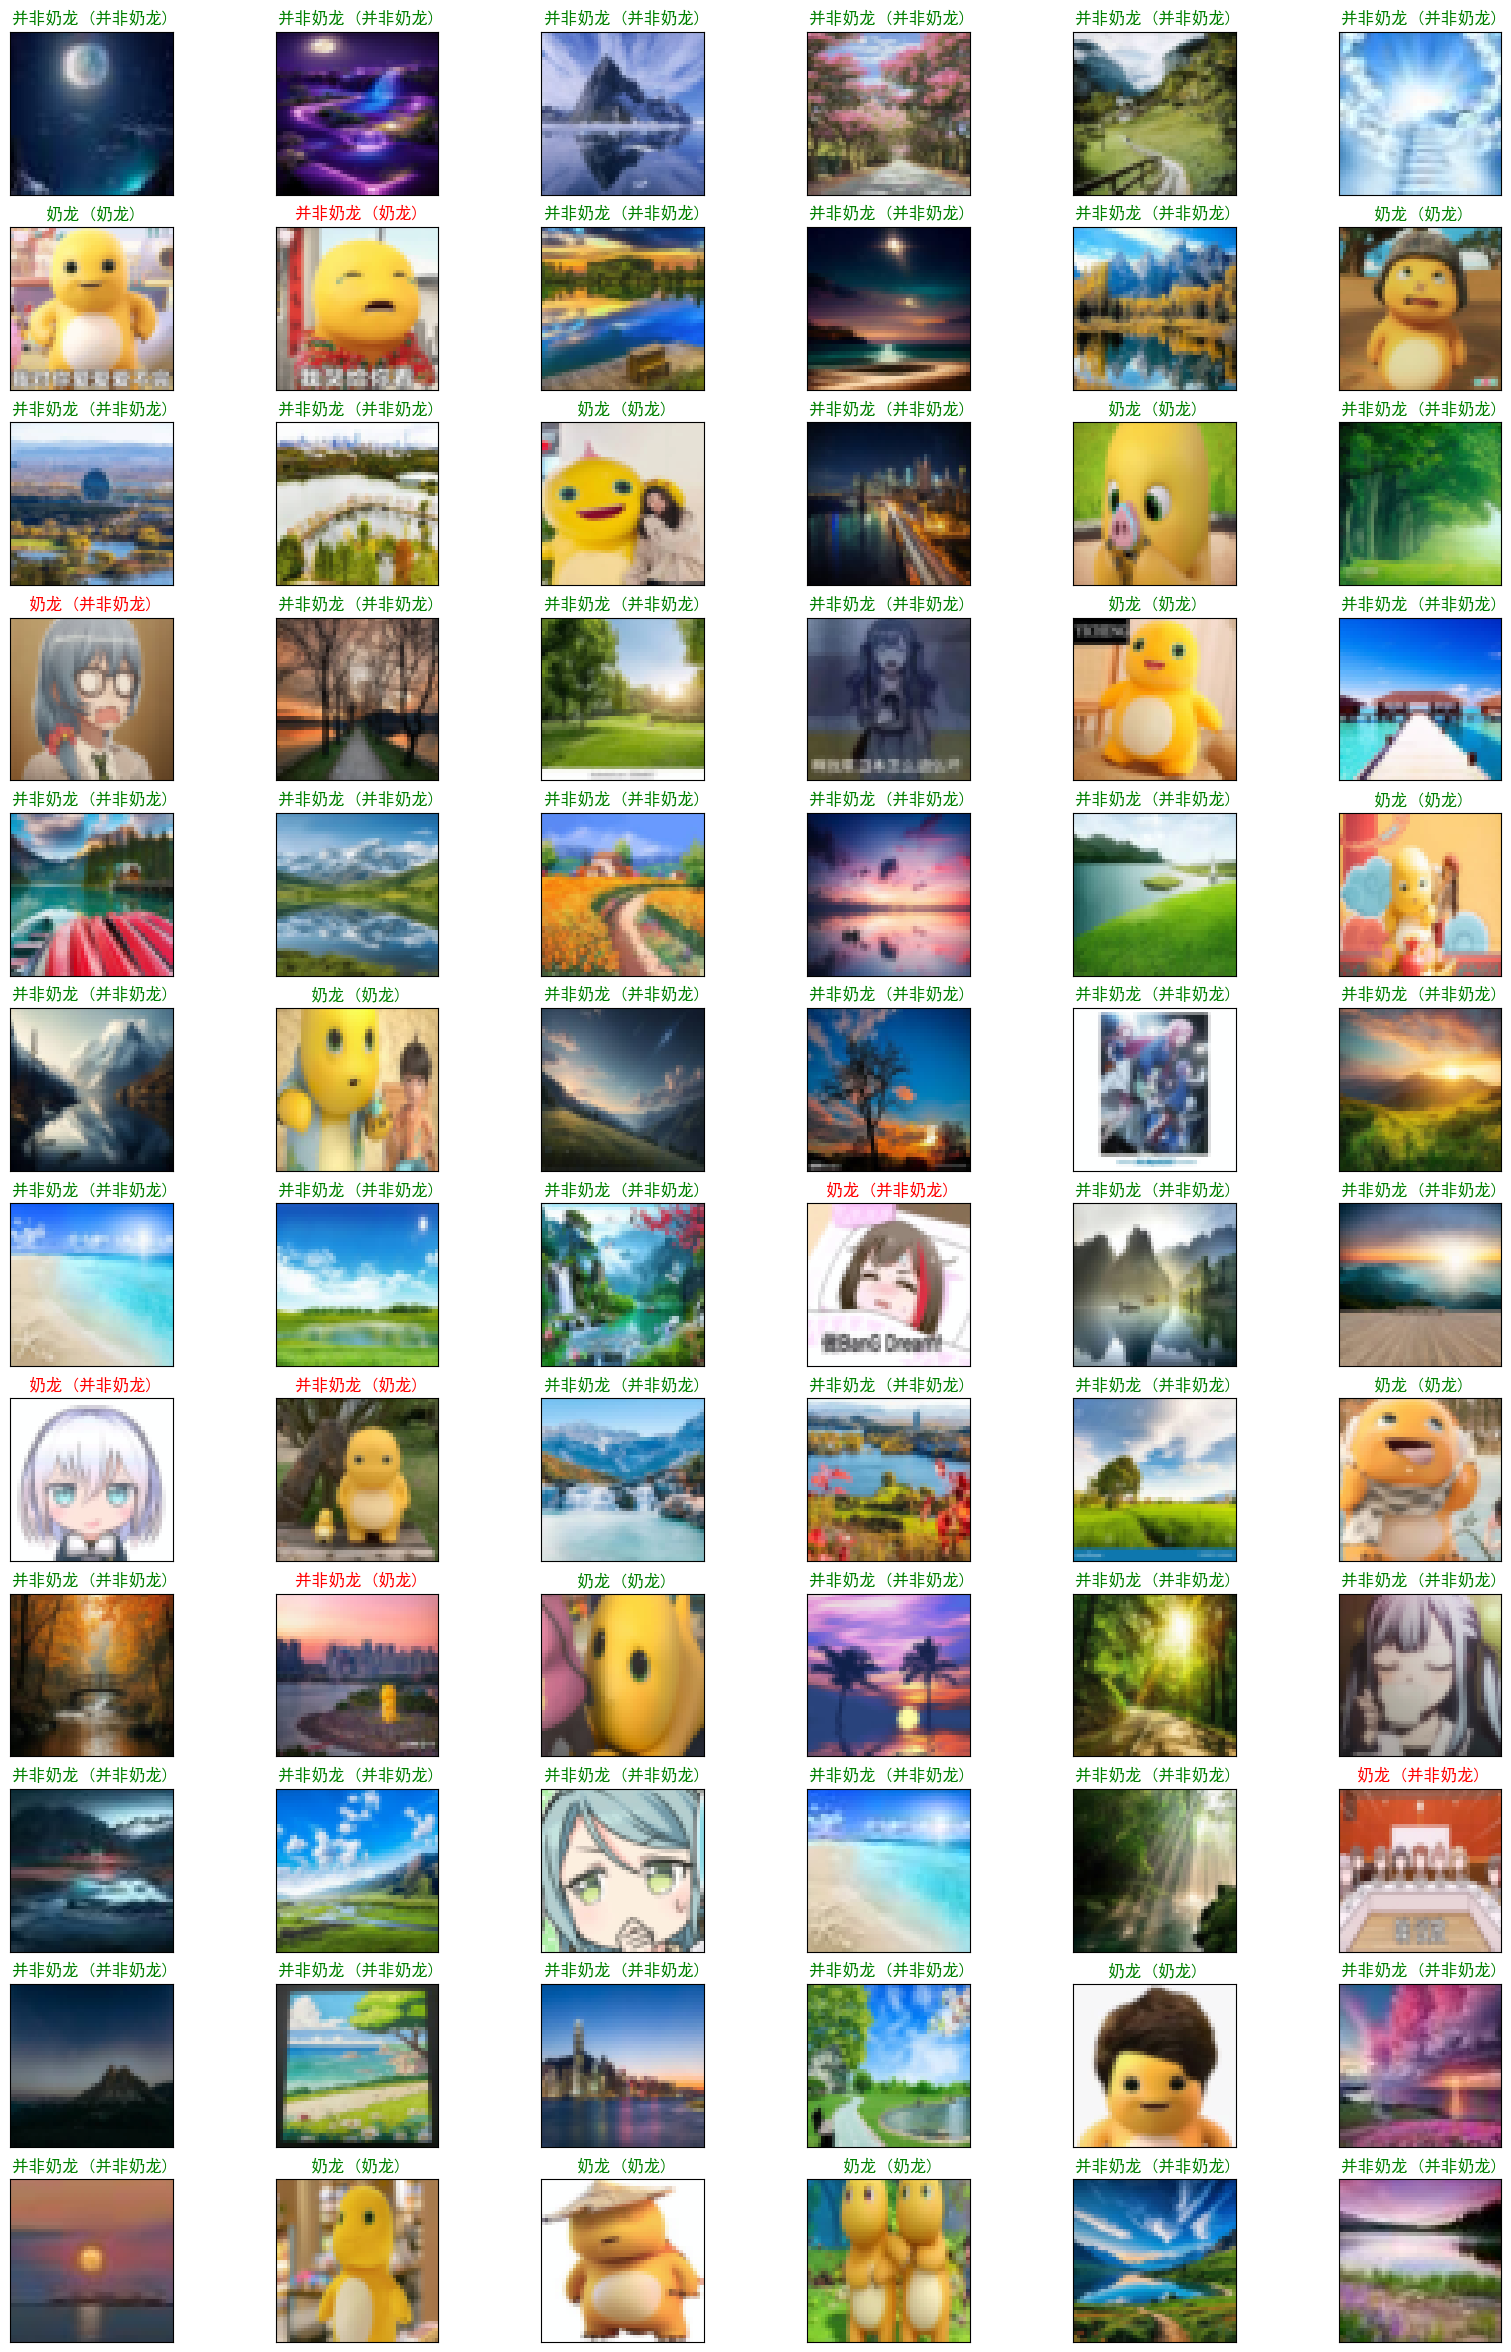

In [284]:
# 重新加载一遍验证集方便测试
valid_datasets = datasets.ImageFolder(os.path.join(data_dir, 'valid'), data_transforms['valid'])
valid_dataloader = torch.utils.data.DataLoader(valid_datasets, batch_size=batch_size, shuffle=True)

# 得到一个 batch 的测试数据
dataiter = iter(valid_dataloader)
images, labels = dataiter._next_data()

# 将模型切换为验证模式
model_ft.eval()

# 把数据喂给模型得到张量输出
tensor_output: torch.Tensor | None = None

# 根据训练方式要转换不同格式的数据
if train_on_gpu:
    tensor_output = model_ft(images.cuda())
else:
    tensor_output = model_ft(images)


# 获取预测分类结果的张量
_, preds_tensor = torch.max(tensor_output, 1)

# 获取模型得到的分类结果
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# 画图
from utils.image import show_result
show_result(images,preds,labels,rows=12,columns=6,figsize=(20,30))